# Preprocessing of squat or pushup raw coordinate text files into segmented and normalized reps

In [1]:
#=====[ Import dependencies ]====
import numpy as np
import matplotlib.pyplot as plt
import sys
# sys.path.append('/usr/local/lib/python2.7/site-packages')
import pandas as pd
import pickle

# sys.path.append('/Users/admin3/Dropbox/Stanford/Fall-2015/CS221/project/ai_trainer/data')
sys.path.append('../data')
sys.path.append('../data/squat_pushupData_10to20')
sys.path.append('../inference')

#=====[ Import Data ]=====
# import coords1 as cd
import coordKeys as keys
import coordKeysZ as keysZ

#=====[ Import Labels ]======
import labels

%matplotlib inline

/Users/Brandon/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


# Step 1: Import Data

In [5]:
#=====[ Get labels ]=====
y = labels.labels15
# print 'Number of labeled squats: %d' % len(y)

#=====[ Get raw text files that specify x, y, z coordinates for each joint for each frame ]=====
file_to_open =  '../data/raw_data/squat_pushupData_10to20/squatData13.txt'
# file_to_save = '../data/squat_coords/squat17.p'

In [6]:
#=====[ Import data from text file ] =====

#=====[ There are parameters we can use to cut off unclean coordinates from either end of our dataframe. We 
#=====[ manually do this here, but in our full pipeline, we automate this ]=====

front_cut = 0
back_cut = 0

data = []
with open(file_to_open) as f:
    for line in f:
        try:
            data.append([float(x.replace('\r\n','')) for x in line.split(',')])
        except Exception as e:
            print e

#=====[ Put data in data frame, apply front and back cut, and reset index ]=====
df = pd.DataFrame(data, columns=keysZ.columns)
df = df[front_cut:df.shape[0]-back_cut]
df = df.set_index([range(0,df.shape[0])])
df.head()

,SpineBaseX,SpineBaseY,SpineBaseZ,SpineMidX,SpineMidY,SpineMidZ,NeckX,NeckY,NeckZ,HeadX,...,HandTipLeftZ,ThumbLeftX,ThumbLeftY,ThumbLeftZ,HandTipRightX,HandTipRightY,HandTipRightZ,ThumbRightX,ThumbRightY,ThumbRightZ
0,263.104919,174.818909,2.459708,264.268982,125.396904,2.454690,265.416779,76.684052,2.437456,265.499786,...,2.305079,243.933044,192.064728,2.268467,383.498108,50.996933,2.374507,368.429321,58.428131,2.406143
1,263.215820,175.213943,2.414441,264.262238,125.240326,2.442008,265.403656,76.679108,2.437677,265.522247,...,2.426420,164.144028,44.143250,2.450143,377.598572,43.199921,2.358433,364.713623,49.998352,2.416857
2,264.136200,173.187103,2.412615,264.593689,124.594658,2.437691,265.411591,76.689972,2.437383,265.539978,...,2.429082,173.382568,37.293640,2.426909,370.047913,40.323441,2.370817,358.668152,45.335098,2.417667
3,264.404480,172.264862,2.411652,264.741241,124.129387,2.435206,265.411469,76.691391,2.437093,265.548248,...,2.431059,184.625061,40.621124,2.442875,362.123566,33.202423,2.379206,350.555969,40.885727,2.414000
4,264.476807,172.044189,2.411136,264.880463,123.929939,2.433811,265.483307,76.702988,2.436774,265.549957,...,2.411451,192.250656,35.749924,2.449250,352.409241,25.838058,2.391559,342.909454,38.182144,2.420182


# Step 2: Isolate Individual Squats

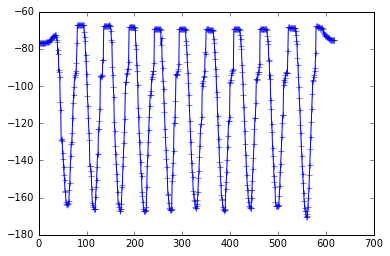

In [7]:
#=====[ Extract y_coords for Neck -- provides a stable point of reference ]=====
y_coords = np.array(df.get('NeckY'))
plt.plot(-y_coords,marker='+')

# Get Max Indices

In [8]:
#=====[ Returns true if the specified index of y_coords is a minimum value ]=====
def is_min(y_coords, height, gradient, index, epsilon, beta):
    if np.abs(y_coords[index] - height)/height < epsilon:
        for i in range(1,beta):
            if gradient[index - i] > 0 or gradient[index + i - 1] < 0:
                return False
        return True
        
#=====[ Returns true if we suspect that we are in a new repetition ]=====
def in_new_squat(y_coords, height, index, delta):
    return abs((y_coords[index] - height)/height) > delta

#=====[ Gets local maxes within accepted epsilon of global max and with max len(y_coors)/gamma maxes ]=====
#=====[ For squats: usual epsilon ~ 0.2, gamma ~ 20, delta ~ 0.5, beta ~ 1 ]=====
#=====[ For pushups: usual epsilon ~ 0.2, gamma ~ 20, delta ~ 0.2, beta ~ 1 ]=====

def get_local_mins(y_coords, epsilon=0.25, gamma=50, delta=0.5, beta=2):
    
    local_mins = []
    height = np.min(y_coords[len(y_coords)/3:len(y_coords)*2/3])
    gradient = np.gradient(y_coords)
    
    #=====[ Checks gradients to make sure we are looking at a local min ]=====
    min_located = False
    for index, dy in enumerate(gradient[2:]):
        if(min_located):
            if in_new_squat(y_coords, height, index, delta):
                min_located = False       
            else:
                continue
                
        if  is_min(y_coords, height, gradient, index, epsilon, beta + 1):
            local_mins.append(index)
            min_located = True
        
    return sorted(local_mins)

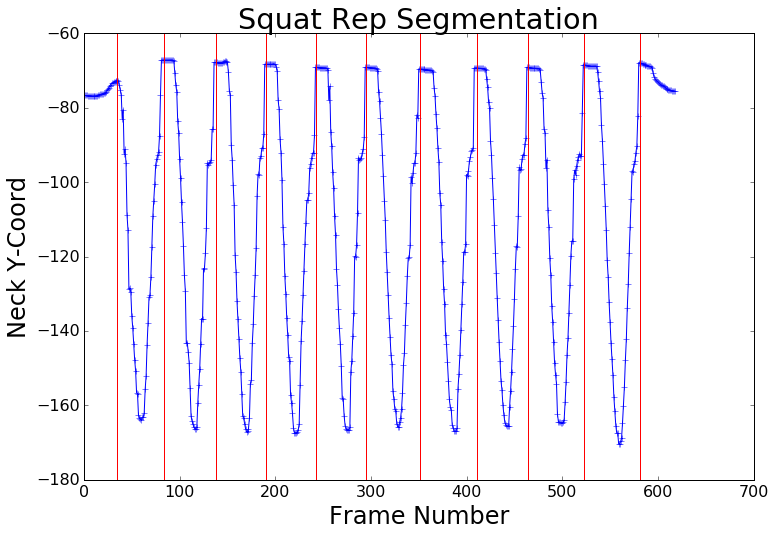

In [9]:
#=====[ Get maxes and plot with y_coords ]=====
mins = get_local_mins(y_coords)
plt.plot(-y_coords,marker='+')

for divide in mins:
    plt.axvline(divide,color='r')

#=====[ Add plot decorations ]=====    
plt.ylabel('Neck Y-Coord')
plt.xlabel('Frame Number')
figure = plt.gcf() # get current figure
figure.set_size_inches(12, 8)
plt.rcParams.update({'font.size': 24})
plt.tick_params(axis='x', labelsize=16)
plt.tick_params(axis='y', labelsize=16)
plt.title('Squat Rep Segmentation')
plt.savefig('squat_separation.png',dpi=200)

# Separate Exercise based on max points found

In [10]:
reps = []

#=====[ Get points from DF between each max found -- constitutes a single squat ]=====
for index,x in enumerate(mins):
    if(index == len(mins) -1 ):
        continue
    rep = (df.loc[x:mins[index+1]-1]).copy(True)
    reps.append(rep.set_index([range(rep.shape[0])]))

print "%d reps extracted, %d labels exracted" % (len(reps), len(y))

10 reps extracted, 10 labels exracted


# Step 3: Normalize Coordinates

In [11]:
# =====[ Helper Functions for getting normalizing parameters ]=====
def y_upper_bound(df):
    return np.min(df['HeadY'])

def y_lower_bound(df):
    return np.median(pd.concat([df['FootRightY'],df['FootLeftY']],axis =0))

def x_zero(df):
    return np.median(df['SpineMidX'])

def z_zero(df):
    return np.median(np.concatenate([df.get('FootLeftZ'),df.get('FootRightZ')],axis=0))

def scaling_factor(df):
    return np.abs(y_upper_bound(df) - y_lower_bound(df))

In [12]:
def normalize(df, reps, z_coords=False):
    
    #=====[ Normalizing constants for the entire set of exercises ]=====
    y_head = y_upper_bound(df)
    scale = scaling_factor(df)
    x_midpoint = x_zero(df)
    z_midpoint = z_zero(df)
    
    for rep in reps:
        
        #=====[ Even columns are x-coordinates, odd columns are y-coordinates -- normalize respectively ]=====
        for index, col in enumerate(rep.columns):
            if index % 3 == 2:
                rep[col] = rep[col].apply((lambda z: ((z - z_midpoint)/scale)))
            elif index % 3 == 1:
                rep[col] = rep[col].apply((lambda y: ((y - y_head)/scale)))
            else:
                rep[col] = rep[col].apply(lambda x: ((x - x_midpoint)/scale))                    

In [13]:
#=====[ Normalize squats: ensure z_coords is set to true if extracting 3-d coordinates ]=====
# from pu_normalization import normalize #<--- This line is used if preprocessing pushups

normalize(df, reps)

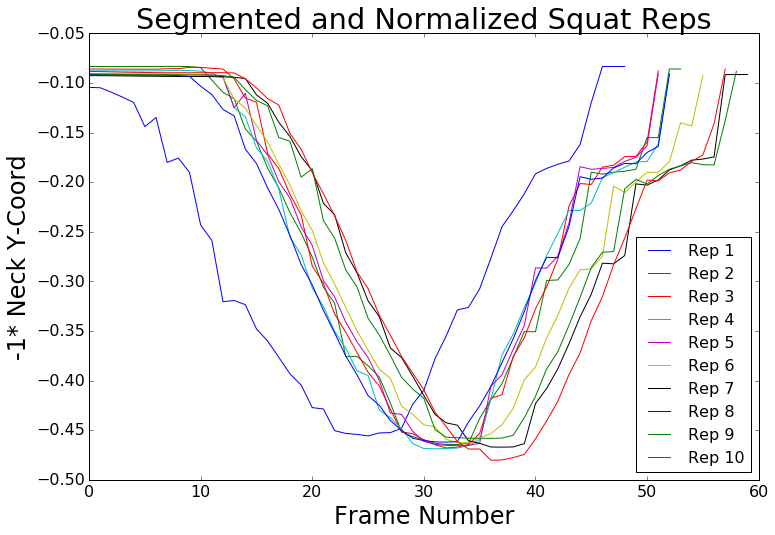

In [14]:
#=====[ Visual comparison between reps ]=====
for index, rep in enumerate(reps):
    plt.plot(-rep.get('NeckY'),label="Rep " + str(index + 1))
plt.legend(loc='lower right', prop={'size':16})
plt.ylabel('-1* Neck Y-Coord')
plt.xlabel('Frame Number')
figure = plt.gcf() # get current figure
figure.set_size_inches(12, 8)
plt.tick_params(axis='x', labelsize=16)
plt.tick_params(axis='y', labelsize=16)
plt.title('Segmented and Normalized Squat Reps')

# Compress reps and labels into a pickle file

In [ ]:
training_data = []

#=====[ Append label to our squats and pickle the (x,y) pairs ]=====
for index, rep in enumerate(reps):
    training_data.append((rep,y[index]))

In [ ]:
#=====[ Save squats in pickle file if desired ]=====
pickle.dump(training_data,open(file_to_save,'wb'))

# Visualize Scaled Body

In [15]:
def plotBody(df,frame):
    coords = np.array(df.loc[frame])
    xs = [coords[i] for i in range(0,coords.size) if i % 3 == 0]
    ys = [-1*coords[i] for i in range(0,coords.size) if i % 3 == 1]    
    zs = [coords[i] for i in range(0,coords.size) if i % 3 == 2]
    plt.plot(xs,ys,linestyle='None',marker='o',markersize=10)
    figure = plt.gcf()
    plt.axis([-.3, .3, -1.1, 0.1])
    figure.set_size_inches(5,8)


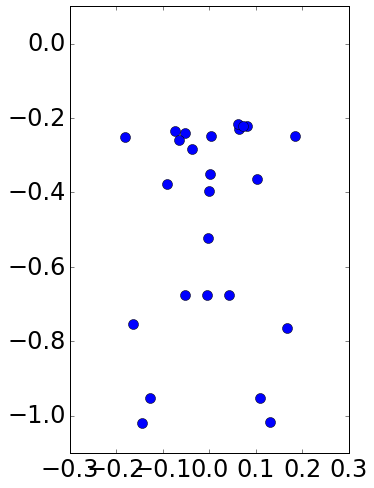

In [16]:
plotBody(reps[1],40)